## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

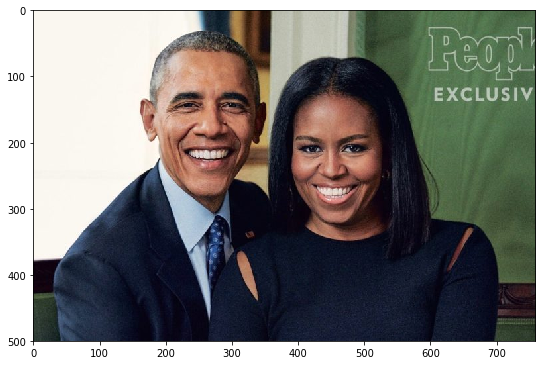

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


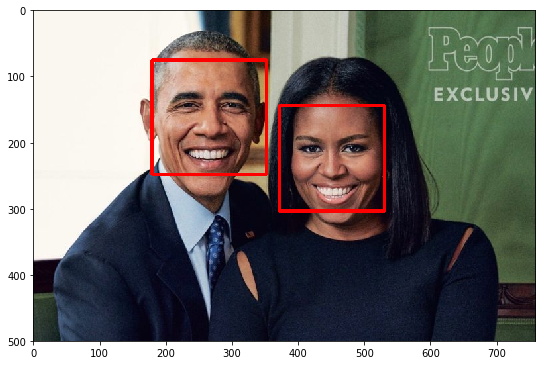

In [50]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [5]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
    plt.show()

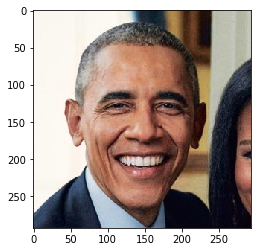

torch.Size([96, 96])


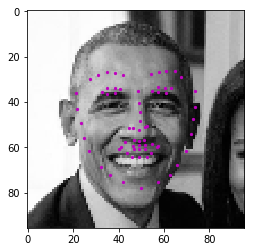

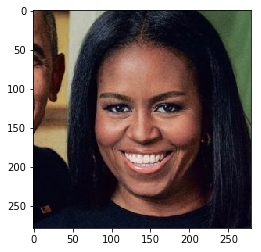

torch.Size([96, 96])


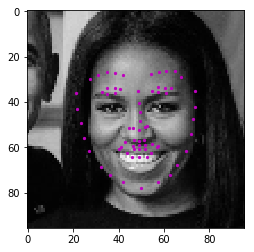

In [57]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
padding_w = padding_h = 60
points = np.zeros((2, 68, 2), np.uint8)
for index, (x,y,w,h) in enumerate(faces):
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
    plt.imshow(roi)
    plt.show()
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (96,96))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = np.expand_dims(roi, 0)
    roi.transpose((2, 0, 1))
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    
    # add Batch_size dimension
    roi.unsqueeze_(0)
    
    output = net(roi)
    output = output.view(output.size()[0], 68, -1)
    output = np.squeeze(output.detach().numpy())
    # undo normalization of keypoints  
    output = output*50.0+100
    
    roi = np.squeeze(roi)
    points[index] = output
    print(roi.shape)
    #roi = cv2.resize(roi.numpy(), (96, 96))

    ## TODO: Display each detected face and the corresponding keypoints
    show_all_keypoints(roi, output)

(293, 293, 3)
(279, 279, 3)


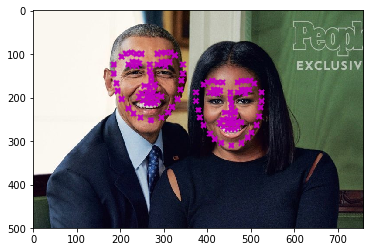

In [73]:
padding_w = padding_h = 60

orig_image = np.copy(image)
plt.imshow(orig_image, cmap='gray')
for index,(x,y,w,h) in enumerate(faces):
    
    # print(x,y,w,h)
    
    # Select the region of interest that is the face in the image
    # i used padding_w = padding_h = 60
    
    # get roi 
    roi = image_copy[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
    
    # create a blank cv2 image with dimensions of out input image 96x96
    blank_image = np.zeros((96,96,3), np.uint8)
    
    # create a dest blank image to save the key points in the =resized roi size
    dest_image = np.zeros(roi.shape, np.uint8)
    print(roi.shape)
    
    # convert keypoints to ints
    # points[0] has Obama face keypoints and points[1]: Michelle
    int_points = points[index].astype(int)
    
    # update blank image with pixel value 255 for the indicies of keypoints
    blank_image[int_points[:,0],int_points[:,1],0] = 255
    
    # create a resized array of size (y+h+padding_h - (y-padding_)) and (x+w+padding_w - (x-padding_w))
    # for Barack its 293x293 and Michelle its 279x279
    # then resize the blank_image with keypoitns to the new size
    resized_roi = cv2.resize(blank_image, (w + 2 * padding_w, h + 2* padding_w),interpolation = cv2.INTER_CUBIC)
    # transpose the dest image due to cv2 origin
    cv2.transpose(resized_roi, dest_image)    
    numpy_resized = np.asarray(dest_image)
    
    # get all resized keypoints from the resized image.
    # these should be where all the pixel values are greater than 0
    resized_key_points = np.asarray(np.where(dest_image[:,:,0] > 0))
    
    # update the resized 2d points to translate them
    resized_key_points[0,:] = resized_key_points[0,:] + y - 60
    resized_key_points[1,:] = resized_key_points[1,:] + x - 60
    plt.scatter(x = resized_key_points[1, :] ,y= resized_key_points[0, :], s=1, marker='.', c='m')
    